In [2]:
from pyspark.sql import SparkSession

# Start a Spark session
spark = SparkSession.builder.appName("JobPostingsAnalysis").getOrCreate()

# Load the CSV file into a Spark DataFrame
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("/home/ubuntu/Assignment2/data/lightcast_job_postings.csv")

# Register the DataFrame as a temporary SQL view
df.createOrReplaceTempView("job_postings")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

# comment the lines below when rendering the submission
df.printSchema() 
df.show(5)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/08 01:49:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/08 01:49:37 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATIO

+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

**Create table**

In [3]:
#Industries Dimension Table
from pyspark.sql.functions import col, monotonically_increasing_id

industries_df = df.select(
    col("naics_2022_6"),
    col("naics_2022_6_name"),
    col("soc_5").alias("soc_code"),
    col("soc_5_name").alias("soc_name"),
    col("lot_specialized_occupation_name").alias("specialized_occupation"),
    col("lot_occupation_group").alias("occupation_group")
).distinct().withColumn("industry_id", monotonically_increasing_id())

# Rearrange columns to have industry_id first
industries_df = industries_df.select(
    "industry_id",
    "naics_2022_6",
    "naics_2022_6_name",
    "soc_code",
    "soc_name",
    "specialized_occupation",
    "occupation_group"
)
industries_df.show(5, truncate=False)

industries = industries_df.toPandas()
industries.head()

+-----------+------------+---------------------------------------------+--------+---------------+----------------------+----------------+
|industry_id|naics_2022_6|naics_2022_6_name                            |soc_code|soc_name       |specialized_occupation|occupation_group|
+-----------+------------+---------------------------------------------+--------+---------------+----------------------+----------------+
|0          |541613      |Marketing Consulting Services                |15-2051 |Data Scientists|SAP Analyst / Admin   |2310            |
|1          |311513      |Cheese Manufacturing                         |15-2051 |Data Scientists|Data Analyst          |2311            |
|2          |522110      |Commercial Banking                           |15-2051 |Data Scientists|SAP Analyst / Admin   |2310            |
|3          |485310      |Taxi and Ridesharing Services                |15-2051 |Data Scientists|Data Analyst          |2311            |
|4          |713990      |All Othe

,industry_id,naics_2022_6,naics_2022_6_name,soc_code,soc_name,specialized_occupation,occupation_group
0,0,541613.0,Marketing Consulting Services,15-2051,Data Scientists,SAP Analyst / Admin,2310.0
1,1,311513.0,Cheese Manufacturing,15-2051,Data Scientists,Data Analyst,2311.0
2,2,522110.0,Commercial Banking,15-2051,Data Scientists,SAP Analyst / Admin,2310.0
3,3,485310.0,Taxi and Ridesharing Services,15-2051,Data Scientists,Data Analyst,2311.0
4,4,713990.0,All Other Amusement and Recreation Industries,15-2051,Data Scientists,Data Analyst,2311.0


In [ ]:
#Companies Dimension Table
companies_df = df.select(
    col("COMPANY").alias("company_id"),
    col("COMPANY_NAME").alias("company_name"), 
    col("COMPANY_RAW").alias("company_raw"), 
    col("COMPANY_IS_STAFFING").alias("company_is_staffing")
).dropDuplicates(["company_id"]).filter(
        (col("COMPANY").isNotNull()) &
        (col("COMPANY_NAME").isNotNull()) &
        (col("COMPANY_NAME") != "Unclassified")   # drop Unclassified
    )
companies_df = companies_df.select(
    "company_id",
    "company_name",
    "company_raw",
    "company_is_staffing",
)

companies_df.show(5, truncate=False)

companies = companies_df.toPandas()
companies.head()

+----------+-------------------+-------------------+-------------------+
|company_id|company_name       |company_raw        |company_is_staffing|
+----------+-------------------+-------------------+-------------------+
|12        |Adecco             |Unknown            |true               |
|20        |Amazon             |Amazon             |false              |
|42        |Johnson & Johnson  |Johnson & Johnson  |false              |
|99        |UnitedHealth Group |UnitedHealth Group |false              |
|454       |Carter Bank & Trust|Carter Bank & Trust|false              |
+----------+-------------------+-------------------+-------------------+
only showing top 5 rows


,company_id,company_name,company_raw,company_is_staffing
0,12,Adecco,Unknown,True
1,20,Amazon,Amazon,False
2,42,Johnson & Johnson,Johnson & Johnson,False
3,99,UnitedHealth Group,UnitedHealth Group,False
4,454,Carter Bank & Trust,Carter Bank & Trust,False


In [5]:
#locations Dimension Table
from pyspark.sql.functions import col, monotonically_increasing_id

locations_df = df.select(
    col("LOCATION").alias("location_id"),
    col("CITY_NAME").alias("city_name"),
    col("STATE_NAME").alias("state_name"),
    col("COUNTY_NAME").alias("county_name"),
    col("MSA").alias("msa"),
    col("MSA_NAME").alias("msa_name"),
).filter(
    (col("LOCATION").isNotNull()) &
    (col("LOCATION") != '{"lat": 0,\n  "lon": 0\n}') & 
    (~col("CITY_NAME").like("[Unknown%")) & 
    (~col("COUNTY_NAME").like("[Unknown%"))
).dropDuplicates(["location_id"])

# Rearrange columns to have location_id first
locations_df = locations_df.select(
    "location_id",
    "city_name",
    "state_name",
    "county_name",
    "msa",
    "msa_name"
)
locations_df.show(10, truncate=False)

locations = locations_df.toPandas()
locations.head()


+-------------------------------------------------+---------------+----------+------------+-----+---------------------------+
|location_id                                      |city_name      |state_name|county_name |msa  |msa_name                   |
+-------------------------------------------------+---------------+----------+------------+-----+---------------------------+
|{\n  "lat": 19.5208333,\n  "lon": -155.9225\n}   |Kealakekua, HI |Hawaii    |Hawaii, HI  |25900|Hilo, HI                   |
|{\n  "lat": 19.639994,\n  "lon": -155.9969261\n} |Kailua-Kona, HI|Hawaii    |Hawaii, HI  |25900|Hilo, HI                   |
|{\n  "lat": 20.0230556,\n  "lon": -155.6716667\n}|Waimea, HI     |Hawaii    |Kauai, HI   |28180|Kapaa, HI                  |
|{\n  "lat": 20.7644275,\n  "lon": -156.4450063\n}|Kihei, HI      |Hawaii    |Maui, HI    |27980|Kahului-Wailuku-Lahaina, HI|
|{\n  "lat": 20.8893351,\n  "lon": -156.4729469\n}|Kahului, HI    |Hawaii    |Maui, HI    |27980|Kahului-Wailuku-Lahai

,location_id,city_name,state_name,county_name,msa,msa_name
0,"{\n ""lat"": 19.5208333,\n ""lon"": -155.9225\n}","Kealakekua, HI",Hawaii,"Hawaii, HI",25900.0,"Hilo, HI"
1,"{\n ""lat"": 19.639994,\n ""lon"": -155.9969261\n}","Kailua-Kona, HI",Hawaii,"Hawaii, HI",25900.0,"Hilo, HI"
2,"{\n ""lat"": 20.0230556,\n ""lon"": -155.6716667\n}","Waimea, HI",Hawaii,"Kauai, HI",28180.0,"Kapaa, HI"
3,"{\n ""lat"": 20.7644275,\n ""lon"": -156.4450063\n}","Kihei, HI",Hawaii,"Maui, HI",27980.0,"Kahului-Wailuku-Lahaina, HI"
4,"{\n ""lat"": 20.8893351,\n ""lon"": -156.4729469\n}","Kahului, HI",Hawaii,"Maui, HI",27980.0,"Kahului-Wailuku-Lahaina, HI"


In [6]:
#Job_postings Fact Table
from pyspark.sql.functions import col, monotonically_increasing_id

job_postings_df = df.select(
    col("ID").alias("job_id"),
    col("TITLE_RAW").alias("title_raw"),
    col("TITLE_CLEAN").alias("title_clean"),
    col("COMPANY").alias("company_id"),                # FK to companies
    col("NAICS_2022_6").alias("industry_id"),          # FK to industries
    col("EMPLOYMENT_TYPE_NAME").alias("employment_type_name"),
    col("REMOTE_TYPE_NAME").alias("remote_type_name"),
    col("BODY").alias("body"),
    col("MIN_YEARS_EXPERIENCE").alias("min_years_experience"),
    col("MAX_YEARS_EXPERIENCE").alias("max_years_experience"),
    col("SALARY").alias("salary"),
    col("SALARY_FROM").alias("salary_from"),
    col("SALARY_TO").alias("salary_to"),
    col("LOCATION").alias("location_id"),              # FK to locations
    col("POSTED").alias("posted"),
    col("EXPIRED").alias("expired"),
    col("DURATION").alias("duration")
).dropDuplicates(["job_id"])


In [7]:
base_path = "/home/ubuntu/Assignment2/tables"

# Save Industries
industries_df.coalesce(1).write.mode("overwrite") \
    .option("header", "true") \
    .csv(f"{base_path}/industries")

# Save Companies
companies_df.coalesce(1).write.mode("overwrite") \
    .option("header", "true") \
    .csv(f"{base_path}/companies")

# Save Locations
locations_df.coalesce(1).write.mode("overwrite") \
    .option("header", "true") \
    .csv(f"{base_path}/locations")

# Save Job Postings
job_postings_df.coalesce(1).write.mode("overwrite") \
    .option("header", "true") \
    .csv(f"{base_path}/job_postings")

In [20]:
# Register industries table as a temp view
industries_df.createOrReplaceTempView("industries")
companies_df.createOrReplaceTempView("companies")
locations_df.createOrReplaceTempView("locations")
job_postings_df.createOrReplaceTempView("job_postings")

**Example of related explanation for the query**

In [10]:
top_5_job_titles_raw = spark.sql("""
    SELECT TITLE_RAW, COUNT(*) AS job_count
    FROM job_postings
    GROUP BY TITLE_RAW
    ORDER BY job_count DESC
    LIMIT 5
""")

top_5_job_titles_raw.show(5, truncate=False)

+-----------------------------+---------+
|TITLE_RAW                    |job_count|
+-----------------------------+---------+
|Data Analyst                 |4201     |
|Enterprise Architect         |808      |
|Senior Data Analyst          |724      |
|Business Intelligence Analyst|686      |
|Data Modeler                 |281      |
+-----------------------------+---------+



In [11]:
import pandas as pd

top_5_job_titles_pd = top_5_job_titles_raw.toPandas()
top_5_job_titles_pd

,TITLE_RAW,job_count
0,Data Analyst,4201
1,Enterprise Architect,808
2,Senior Data Analyst,724
3,Business Intelligence Analyst,686
4,Data Modeler,281


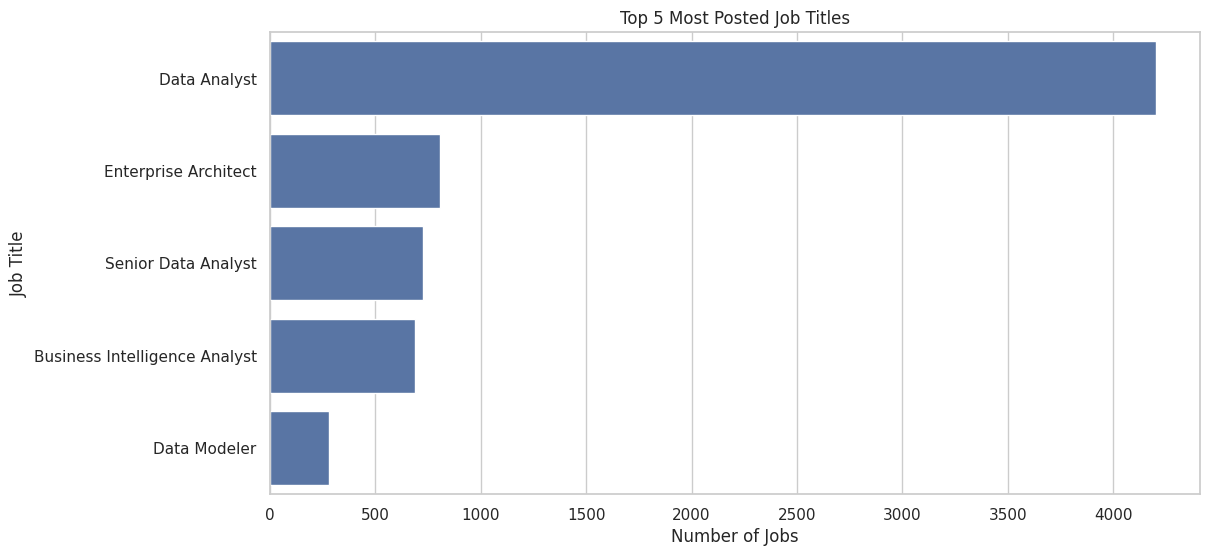

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme(style="whitegrid")

# Set figure size
plt.figure(figsize=(12, 6))

# Create a bar plot
ax = sns.barplot(
   data=top_5_job_titles_pd, 
   x="job_count", 
   y="TITLE_RAW", 
   # palette="Paired",
   # hue="specialized_occupation",
)

# Set labels and title
ax.set_xlabel("Number of Jobs")
ax.set_ylabel("Job Title")
ax.set_title("Top 5 Most Posted Job Titles")

# Save the figure
plt.savefig("output/jobs_top_5.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [13]:
#Query 1: Industry-Specific Salary Trends Grouped by Job Title
query1 = spark.sql("""
    SELECT 
    i.naics_2022_6_name AS industry_name,
    i.specialized_occupation,
    PERCENTILE_APPROX(j.salary, 0.5) AS median_salary
FROM job_postings j
JOIN industries i
    ON j.industry_id = i.naics_2022_6
WHERE j.salary IS NOT NULL
      AND j.salary > 0
      AND i.naics_2022_6 = '518210'
GROUP BY i.naics_2022_6_name, i.specialized_occupation
ORDER BY median_salary DESC
""")


query1.show(10, truncate=False)
query1_pd = query1.toPandas()
query1_pd.head()

+--------------------------------------------------------------------------------------+--------------------------------+-------------+
|industry_name                                                                         |specialized_occupation          |median_salary|
+--------------------------------------------------------------------------------------+--------------------------------+-------------+
|Computing Infrastructure Providers, Data Processing, Web Hosting, and Related Services|Financial Data Analyst          |134984       |
|Computing Infrastructure Providers, Data Processing, Web Hosting, and Related Services|Data Quality Analyst            |134984       |
|Computing Infrastructure Providers, Data Processing, Web Hosting, and Related Services|Marketing Analyst               |134984       |
|Computing Infrastructure Providers, Data Processing, Web Hosting, and Related Services|Data Analyst                    |134984       |
|Computing Infrastructure Providers, Data Proces

,industry_name,specialized_occupation,median_salary
0,"Computing Infrastructure Providers, Data Proce...",Financial Data Analyst,134984
1,"Computing Infrastructure Providers, Data Proce...",Data Quality Analyst,134984
2,"Computing Infrastructure Providers, Data Proce...",Marketing Analyst,134984
3,"Computing Infrastructure Providers, Data Proce...",Data Analyst,134984
4,"Computing Infrastructure Providers, Data Proce...",Enterprise Architect,134984


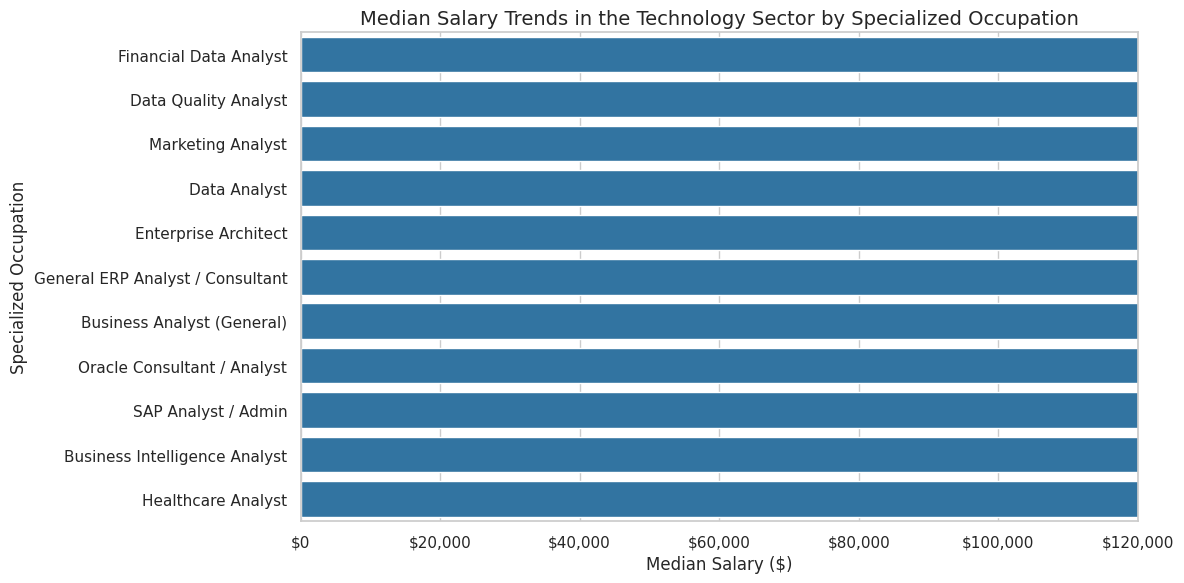

In [ ]:
# Visualization using Plotly
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

query1_df = query1.toPandas()

sns.set_theme(style="whitegrid")

query1_df = (
    query1_df
    .dropna(subset=["specialized_occupation", "median_salary"])
    .sort_values("median_salary", ascending=False)
)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data=query1_df,
    x="median_salary",
    y="specialized_occupation",
    color="#1f77b4",   
)

ax.set_title("Median Salary Trends in the Technology Sector by Specialized Occupation", fontsize=14)
ax.set_xlabel("Median Salary ($)", fontsize=12)
ax.set_ylabel("Specialized Occupation", fontsize=12)


ax.set_xlim(0, 120000)
ax.set_xticks(range(0, 120001, 20000))
ax.set_xticklabels([f"${x:,}" for x in range(0, 120001, 20000)])

plt.tight_layout()

# Save the figure
plt.savefig("output/query1.png", dpi=300, bbox_inches="tight")

plt.show()



The **median salary** for all positions is $134,984. Since there is no real salary information in the data, a default estimated value automatically filled in by the system is used.

In [29]:
# Query 2: Top 5 Companies with the Most Remote Jobs in California

query2 = spark.sql("""
    SELECT 
        c.company_name,
        COUNT(*) AS remote_jobs
   FROM job_postings j
    LEFT JOIN companies c ON j.company_id = c.company_id
    LEFT JOIN locations l ON j.location_id = l.location_id
    WHERE j.remote_type_name = 'Remote'
      AND l.state_name = 'California'
     AND c.company_name IS NOT NULL
    GROUP BY c.company_name
    ORDER BY remote_jobs DESC
    LIMIT 5
""")

query2.show(truncate=False)
query2_pd = query2.toPandas()
query2_pd.head()

+----------------------------------------------+-----------+
|company_name                                  |remote_jobs|
+----------------------------------------------+-----------+
|Kaiser Permanente                             |33         |
|University of California                      |23         |
|The Judge Group                               |21         |
|California Public Employees' Retirement System|12         |
|Cognizant Technology Solutions                |11         |
+----------------------------------------------+-----------+



,company_name,remote_jobs
0,Kaiser Permanente,33
1,University of California,23
2,The Judge Group,21
3,California Public Employees' Retirement System,12
4,Cognizant Technology Solutions,11


/tmp/ipykernel_1333/1084421839.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


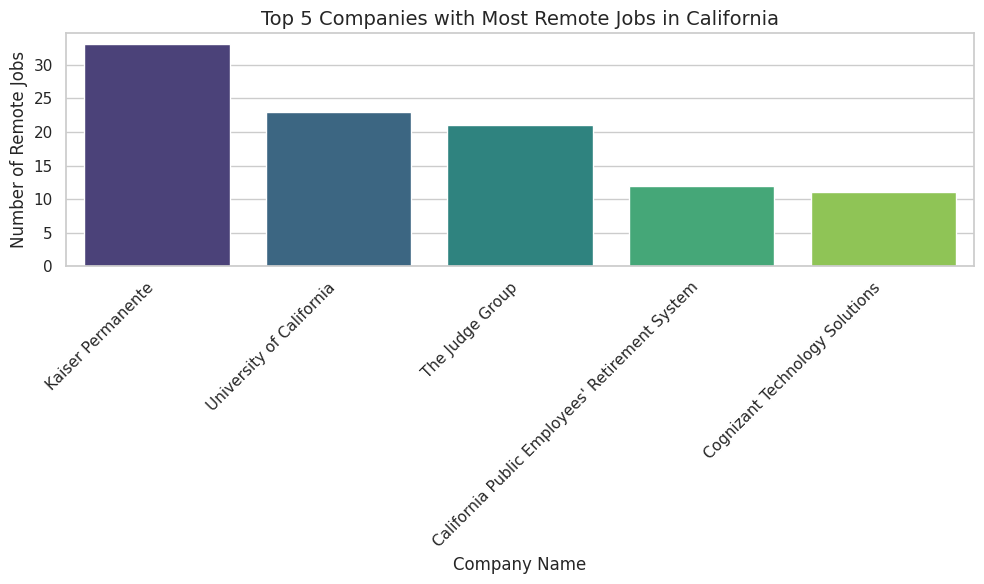

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(
    data=query2_pd, 
    x="company_name", 
    y="remote_jobs", 
    palette="viridis"
)

plt.title("Top 5 Companies with Most Remote Jobs in California", fontsize=14)
plt.xlabel("Company Name")
plt.ylabel("Number of Remote Jobs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
# Save the figure
plt.savefig("output/Query2.png", dpi=300, bbox_inches="tight")
plt.show()

The **University of California and Kaiser Permanente** are leading in the number of remote positions, demonstrating the shift towards flexible working models in the education and healthcare sectors.

In [41]:
# Query 3: Monthly Job Posting Trends in California
query3 = spark.sql("""
    SELECT 
        YEAR(TO_DATE(j.posted, 'M/d/yyyy')) AS year,
        MONTH(TO_DATE(j.posted, 'M/d/yyyy')) AS month,
        COUNT(*) AS job_count
    FROM job_postings j
    JOIN locations l
        ON j.location_id = l.location_id
    WHERE l.state_name = 'California'
        AND j.posted IS NOT NULL
    GROUP BY year, month
    ORDER BY year, month
""")

# pandas to complete the months
query3_pd = query3.toPandas()
query3_pd = query3_pd.set_index(['year','month']).unstack(fill_value=0).stack().reset_index()
query3_pd.head()


/tmp/ipykernel_1333/76444073.py:18: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  query3_pd = query3_pd.set_index(['year','month']).unstack(fill_value=0).stack().reset_index()


,year,month,job_count
0,2024,5,1451
1,2024,6,1304
2,2024,7,1195
3,2024,8,1348
4,2024,9,1525


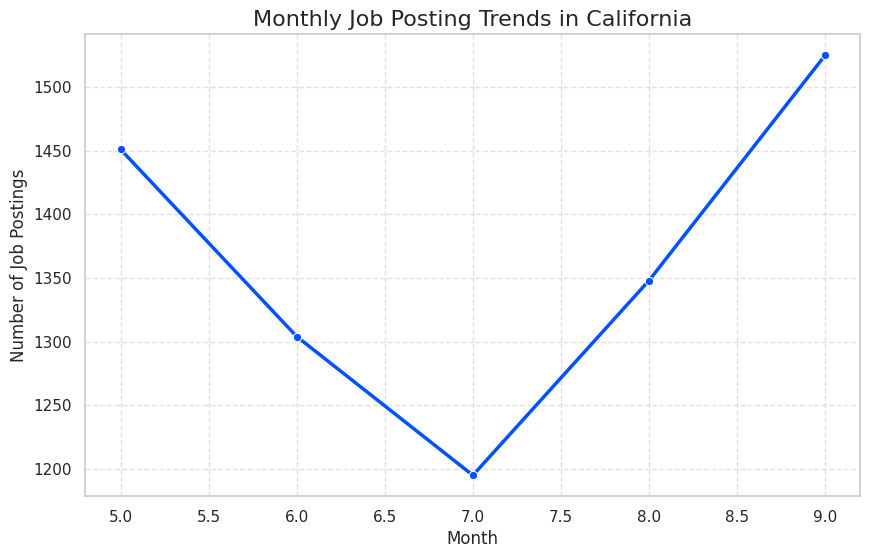

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure the data is sorted by time
query3_pd = query3_pd.sort_values(by=["year", "month"])

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=query3_pd,
    x="month",
    y="job_count",
    marker="o",
    color = "#0051FF",    
    linewidth=2.5
)

plt.title("Monthly Job Posting Trends in California", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Job Postings", fontsize=12)

# Set the X-axis range and interval[5.0, 5.5, 6.0, ..., 9.0]
plt.xticks(ticks=[x/2 for x in range(10, 19)], labels=[x/2 for x in range(10, 19)])  

plt.grid(True, linestyle="--", alpha=0.6)
# Save the figure
plt.savefig("output/Query 3.png", dpi=300, bbox_inches="tight")
plt.show()

**Job Posting** declined in the middle of summer and rebounded in August, demonstrating seasonal recruitment patterns related to the business cycle.


In [ ]:
#Query 4: Salary Comparisons Across Major US Cities

job_postings_df.createOrReplaceTempView("job_postings")
locations_df.createOrReplaceTempView("locations")

msa_map = {
    14460: "Boston",
    47900: "Washington DC",
    35620: "New York",
    41860: "San Francisco",
    42660: "Seattle",
    31080: "Los Angeles",
    19100: "Dallas",
    26420: "Houston",
    12420: "Austin",
    34980: "Nashville",
    28140: "Kansas City",
    19740: "Denver"
}

msa_codes = tuple(msa_map.keys())
query4 = spark.sql(f"""
    SELECT 
        l.msa AS msa_code,
        ROUND(AVG(j.salary), 2) AS avg_salary,
        COUNT(*) AS job_count
    FROM job_postings j
    JOIN locations l
        ON j.location_id = l.location_id
    WHERE j.salary IS NOT NULL
        AND j.salary > 0
        AND l.msa IN {msa_codes}
    GROUP BY l.msa
    ORDER BY avg_salary DESC
""")

query4.show(truncate=False)

query4_pd = query4.toPandas()
query4_pd["city"] = query4_pd["msa_code"].astype(int).map(msa_map)

# average salary from high to low
query4_pd = query4_pd.sort_values("avg_salary", ascending=False)

# output the result
print(query4_pd[["city", "avg_salary", "job_count"]])

+--------+----------+---------+
|msa_code|avg_salary|job_count|
+--------+----------+---------+
|41860   |137333.77 |960      |
|42660   |129379.26 |692      |
|47900   |127371.63 |1436     |
|35620   |125422.02 |2018     |
|14460   |124242.86 |662      |
|12420   |122131.59 |547      |
|28140   |122073.48 |272      |
|19100   |121125.69 |1128     |
|26420   |116442.55 |451      |
|34980   |116311.78 |284      |
|31080   |113847.38 |1257     |
|19740   |112880.72 |669      |
+--------+----------+---------+



             city  avg_salary  job_count
0   San Francisco   137333.77        960
1         Seattle   129379.26        692
2   Washington DC   127371.63       1436
3        New York   125422.02       2018
4          Boston   124242.86        662
5          Austin   122131.59        547
6     Kansas City   122073.48        272
7          Dallas   121125.69       1128
8         Houston   116442.55        451
9       Nashville   116311.78        284
10    Los Angeles   113847.38       1257
11         Denver   112880.72        669


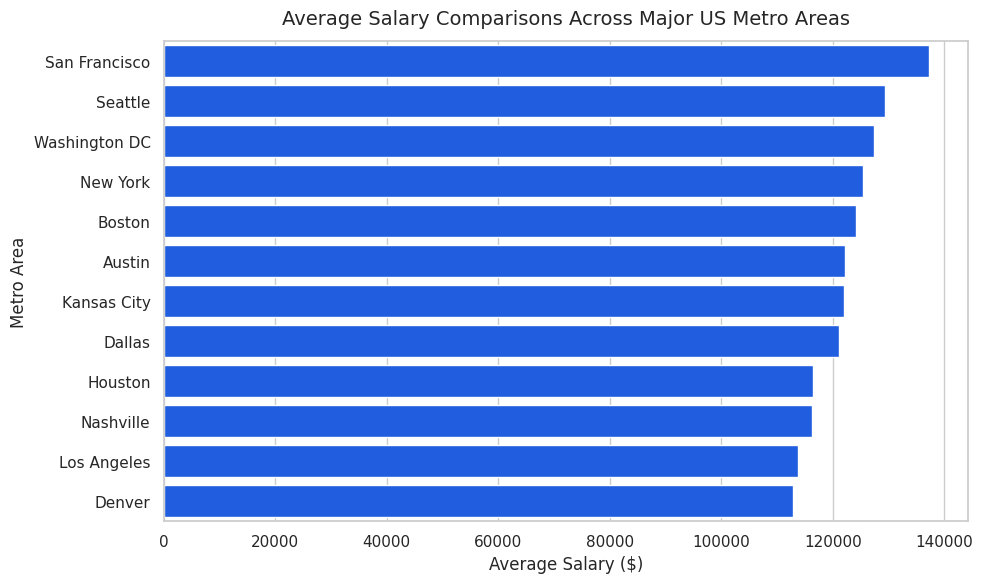

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))


sns.barplot(
    data=query4_pd.sort_values("avg_salary", ascending=False),  # sort salary high to low
    y="city",          
    x="avg_salary",
    color="#0051FF"
)

# Titles
plt.title("Average Salary Comparisons Across Major US Metro Areas", fontsize=14, pad=12)
plt.xlabel("Average Salary ($)", fontsize=12)
plt.ylabel("Metro Area", fontsize=12)

# layout
plt.tight_layout()
#picture save
plt.savefig("output/Query4.png", dpi=300, bbox_inches="tight")
plt.show()


**San Francisco and Seattle** have the highest average salaries, reflecting the continued dominance of technology-driven regional economies.
